In [57]:
import datetime as dt
from authenticate import authenticate_google_calendar 
import matplotlib.pyplot as plt
from googleapiclient.errors import HttpError

# api stuff

In [58]:
import os
from google.auth.exceptions import RefreshError

def authenticate_google_calendar_with_retry():
    try:
        creds = authenticate_google_calendar()
        return creds
    except RefreshError as e:
        if "invalid_grant" in str(e):
            print("Error: Token has been expired or revoked. Deleting token.json and retrying...")
            if os.path.exists("token.json"):
                os.remove("token.json")
            # Retry authentication after removing the token file
            creds = authenticate_google_calendar()
            return creds
        else:
            raise

calendar_name_map = fetch_calendar_names(authenticate_google_calendar_with_retry())
print("Calendar name map:", calendar_name_map)

Calendar name map: {'b7ca60b7b46309b1e408a4a240a5456ca98cb4af51ad62d260ae8ae4fd0ce45d@group.calendar.google.com': 'Timetable', 'en.christian#holiday@group.v.calendar.google.com': 'Christian Holidays', 'o3ddi6qpfar9g43eldqb6ad2l6lipdml@import.calendar.google.com': 'Calendar', 'en.islamic#holiday@group.v.calendar.google.com': 'Muslim Holidays', 'en.judaism#holiday@group.v.calendar.google.com': 'Jewish Holidays', 'en.uk#holiday@group.v.calendar.google.com': 'Holidays in United Kingdom', 'g3uv76g8h69qah3p4i80bv5233up9nd9@import.calendar.google.com': 'https://files-f1.motorsportcalendars.com/f1-calendar_p1_p2_p3_qualifying_sprint_gp.ics?t=1677426916665', '6e609d607f04ff756b9050d7b8444d658f6b7c8914ded6b1066a33491b5b67e0@group.calendar.google.com': 'Time', '0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com': 'Studying', '90c68802d80f0e9b3643757199cad05eeaa8c1d02f655a7c7c5cc2c7de4d41f6@group.calendar.google.com': 'RescueTime', '5b70831851b9eaf56fb749810

In [59]:
def fetch_study_events(service, calendar_id, num_previous_days=30):
    now = dt.datetime.utcnow().isoformat() + "Z"  # 'Z' indicates UTC time
    start_date = dt.datetime.utcnow() - dt.timedelta(days=num_previous_days)
    start_date_iso = start_date.isoformat() + "Z"

    # print(f"Fetching events from {calendar_id} for the past {num_previous_days} days")
    events_result = (
        service.events()
        .list(
            calendarId=calendar_id,
            timeMin=start_date_iso,
            timeMax=now,
            maxResults=10000,
            singleEvents=True,
            orderBy="startTime",
        )
        .execute()
    )
    events = events_result.get("items", [])
    print(f"Found {len(events)} events in the past {num_previous_days} days from {calendar_name_map[calendar_id]}.")

    return events

In [60]:
def get_all_studying_hours_today(service, calendar_id, subjects):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo

    today_start = dt.datetime.now().replace(
        hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone
    ).isoformat()
    today_end = dt.datetime.now().replace(
        hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone
    ).isoformat()
    
    try:
        events_result = service.events().list(
            calendarId=calendar_id,
            timeMin=today_start,
            timeMax=today_end,
            singleEvents=True,
            orderBy='startTime'
        ).execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0
    
    events = events_result.get('items', [])
    
    if not events:
        print("No events found for today.")
        return 0
    
    # List to store non-overlapping intervals from filtered events
    intervals = []
    
    for event in events:
        # Exclude all-day events
        if 'date' in event['start']:
            continue
        
        summary = event.get("summary", "").lower()
        # Only include events that match any subject term
        if not any(term.lower() in summary for terms in subjects.values() for term in terms):
            continue
        
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        start_time = dt.datetime.fromisoformat(start).astimezone(local_timezone)
        end_time = dt.datetime.fromisoformat(end).astimezone(local_timezone)
        
        # Merge overlapping intervals
        new_interval = (start_time, end_time)
        merged = False
        for i, (s, e) in enumerate(intervals):
            if max(s, new_interval[0]) < min(e, new_interval[1]):  # intervals overlap
                intervals[i] = (min(s, new_interval[0]), max(e, new_interval[1]))
                merged = True
                break
        if not merged:
            intervals.append(new_interval)
    
    total_hours = sum((e - s).total_seconds() for s, e in intervals) / 3600
    print(f"Total planned studying hours for today (filtered by subjects): {total_hours:.1f} hours")
    return total_hours


def get_studying_hours_completed_today(service, calendar_id, subjects):
    local_timezone = dt.datetime.now().astimezone().tzinfo
    today_start = dt.datetime.now().replace(
        hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone
    ).isoformat()
    
    try:
        events_result = service.events().list(
            calendarId=calendar_id,
            timeMin=today_start,
            timeMax=dt.datetime.now(tz=local_timezone).isoformat(),
            singleEvents=True,
            orderBy='startTime',
            maxResults=10000,
        ).execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0
    
    events = events_result.get('items', [])
    
    if not events:
        print("No events found for today.")
        return 0
    
    total_hours = 0
    for event in events:
        # Exclude all-day events
        if 'date' in event['start']:
            continue
        
        summary = event.get("summary", "").lower()
        # Only count completed events that match a subject term
        if not any(term.lower() in summary for terms in subjects.values() for term in terms):
            continue
        
        start = event['start']['dateTime']
        end = event['end']['dateTime']
        
        # Use event-provided timeZone if available; otherwise, default to local timezone
        start_tz = event['start'].get('timeZone')
        end_tz = event['end'].get('timeZone')
        if start_tz:
            start_time = dt.datetime.fromisoformat(start).astimezone(dt.timezone.utc)
        else:
            start_time = dt.datetime.fromisoformat(start).astimezone(local_timezone)
        if end_tz:
            end_time = dt.datetime.fromisoformat(end).astimezone(dt.timezone.utc)
        else:
            end_time = dt.datetime.fromisoformat(end).astimezone(local_timezone)
        
        now = dt.datetime.now(tz=local_timezone)
        if end_time <= now:
            duration = end_time - start_time
            total_hours += duration.total_seconds() / 3600
    
    return total_hours

def fetch_daily_studying_hours(service, calendar_id, date):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    start_of_day = date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    end_of_day = date.replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone).isoformat()

    # Attempt to fetch events for the specified day
    try:
        events_result = (
            service.events()
            .list(
                calendarId=calendar_id,
                timeMin=start_of_day,
                timeMax=end_of_day,
                singleEvents=True,
                orderBy="startTime",
                maxResults=10000,
            )
            .execute()
        )
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0  # Return 0 hours if an error occurs

    events = events_result.get('items', [])
    total_hours = 0
    for event in events:
        # skip all-day events
        if 'date' in event['start']:
            continue
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        # Parse the datetime strings into datetime objects
        start_time = dt.datetime.fromisoformat(start)
        end_time = dt.datetime.fromisoformat(end)
        # Calculate duration in hours
        duration = (end_time - start_time).total_seconds() / 3600
        total_hours += duration

    return total_hours

def fetch_daily_subject_hours(service, calendar_id, subject, subject_terms, date):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    start_of_day = date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    end_of_day = date.replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone).isoformat()

    # Attempt to fetch events for the specified day
    try:
        events_result = (
            service.events()
            .list(
                calendarId=calendar_id,
                timeMin=start_of_day,
                timeMax=end_of_day,
                singleEvents=True,
                orderBy="startTime",
                maxResults=10000,
            )
            .execute()
        )
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0  # Return 0 hours if an error occurs

    events = events_result.get('items', [])
    total_hours = 0

    if not subject:
        # loop through all the subjects
        for subject, terms in subject_terms.items():
            for event in events:
                # skip all-day events
                if 'date' in event['start']:
                    continue
                summary = event.get("summary", "").lower()
                if any(term.lower() in summary for term in terms):
                    start = event['start'].get('dateTime', event['start'].get('date'))
                    end = event['end'].get('dateTime', event['end'].get('date'))
                    # Parse the datetime strings into datetime objects
                    start_time = dt.datetime.fromisoformat(start)
                    end_time = dt.datetime.fromisoformat(end)
                    # Calculate duration in hours
                    duration = (end_time - start_time).total_seconds() / 3600
                    total_hours += duration
    else:
        if subject not in subject_terms:
            print(f"Subject '{subject}' not recognized.")
            return 0

        terms = subject_terms[subject]

        for event in events:
            # skip all-day events
            if 'date' in event['start']:
                continue
            summary = event.get("summary", "").lower()
            if any(term.lower() in summary for term in terms):
                start = event['start'].get('dateTime', event['start'].get('date'))
                end = event['end'].get('dateTime', event['end'].get('date'))
                # Parse the datetime strings into datetime objects
                start_time = dt.datetime.fromisoformat(start)
                end_time = dt.datetime.fromisoformat(end)
                # Calculate duration in hours
                duration = (end_time - start_time).total_seconds() / 3600
                total_hours += duration

    return total_hours

# main functions

## studying progress

In [61]:
def plot_studying_progress(service, calendar_ids, subjects):
    total_planned = 0
    total_completed = 0

    # Ensure calendar_ids is a list
    if not isinstance(calendar_ids, list):
        calendar_ids = [calendar_ids]

    # Sum the filtered planned and completed hours from all calendars
    for calendar_id in calendar_ids:
        planned = get_all_studying_hours_today(service, calendar_id, subjects)
        completed = get_studying_hours_completed_today(service, calendar_id, subjects)
        total_planned += planned
        total_completed += completed

    if total_planned == 0:
        percentage_completed = 100
    else:
        percentage_completed = (total_completed / total_planned) * 100

    print(f"Total studying hours completed today: {total_completed:.1f} hours")
    print(f"Percentage of planned studying hours completed today: {round(percentage_completed)}%")

    plt.figure(figsize=(10, 1))
    plt.barh(['Today'], [total_completed], color='skyblue', label='Completed Hours')
    plt.barh(['Today'], [total_planned - total_completed],
             left=[total_completed], color='lightgrey', label='Remaining Hours')
    plt.xlabel('Hours')
    plt.title("Today's Studying Progress (Filtered by Subjects)")
    plt.legend()
    plt.show()

## studying hours over past month

In [62]:
def plot_studying_hours_over_past_month(service, calendar_id):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    now = dt.datetime.now(tz=local_timezone)

    # Fetch data for the last week and last month
    monthly_days = 30
    weekly_days = 7
    daily_hours_month = []
    daily_hours_week = []
    dates_month = [now - dt.timedelta(days=x) for x in range(monthly_days - 1, -1, -1)]
    dates_week = dates_month[monthly_days-weekly_days:]

    for date in dates_month:
        if date == now:
            daily_hours = get_studying_hours_completed_today(service, calendar_id)
        else:
            daily_hours = fetch_daily_studying_hours(service, calendar_id, date)

        daily_hours_month.append(daily_hours)
        if date in dates_week:
            daily_hours_week.append(daily_hours)

    # Calculate averages and other statistics
    average_hours_month = sum(daily_hours_month) / monthly_days
    average_hours_week = sum(daily_hours_week) / weekly_days
    print(f"Average studying hours over the last month: {average_hours_month:.1f} hours")
    print(f"Average studying hours over the last week: {average_hours_week:.1f} hours")

    # Plotting the results for the last month
    plt.figure(figsize=(10, 10))
    plt.barh([date.strftime("%b %d") for date in dates_month], daily_hours_month, color='skyblue')
    plt.xlabel('Hours Studied')
    plt.ylabel('Date')
    plt.title('Studying Hours Over the Last Month')
    plt.axvline(x=average_hours_month, color='green', linestyle='--', label='Monthly Average')
    plt.axvline(x=average_hours_week, color='darkblue', linestyle='--', label='Weekly Average')
    plt.legend()
    plt.tight_layout()
    plt.show()

## subject specific hours over past month

In [63]:
def plot_subject_hours_over_past_month(service, calendar_ids, subject, subjects):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    now = dt.datetime.now(tz=local_timezone)

    # Fetch data for the last week and last month
    monthly_days = 30
    weekly_days = 7
    daily_hours_month = []
    daily_hours_week = []
    dates_month = [now - dt.timedelta(days=x) for x in range(monthly_days - 1, -1, -1)]
    dates_week = dates_month[monthly_days - weekly_days:]

    for date in dates_month:
        daily_hours = 0
        for calendar_id in calendar_ids:
            # Use the same function for all dates, including today
            daily_hours += fetch_daily_subject_hours(service, calendar_id, subject, subjects, date)
        daily_hours_month.append(daily_hours)
        if date in dates_week:
            daily_hours_week.append(daily_hours)

    # Calculate averages and other statistics
    average_hours_month = sum(daily_hours_month) / monthly_days
    average_hours_week = sum(daily_hours_week) / weekly_days
    if subject: print(f"Average {subject} hours over the last month: {average_hours_month:.1f} hours")
    if subject: print(f"Average {subject} hours over the last week: {average_hours_week:.1f} hours")

    # Plotting the results for the last month
    plt.figure(figsize=(10, 10))
    plt.barh(
        [date.strftime("%b %d") for date in dates_month],
        daily_hours_month,
        color='skyblue'
    )
    plt.xlabel('Hours Studied')
    plt.ylabel('Date')
    plt.title(f'{subject if subject else "All"} Hours Over the Last Month')
    plt.axvline(
        x=average_hours_month,
        color='green',
        linestyle='--',
        label='Monthly Average'
    )
    plt.axvline(
        x=average_hours_week,
        color='darkblue',
        linestyle='--',
        label='Weekly Average'
    )
    plt.legend()
    plt.tight_layout()
    plt.show()


## subject specific hours since a given date

In [64]:
def calculate_average_hours_since_date(service, calendar_id, subject, subjects, given_date):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    now = dt.datetime.now(tz=local_timezone)

    # Calculate the number of days since the given date
    delta_days = (now.date() - given_date.date()).days + 1  # Include the given_date itself

    # Fetch all events in the range of given_date to now in one API call
    start_of_given_date = given_date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    now_iso = now.isoformat()

    try:
        events_result = service.events().list(
            calendarId=calendar_id,
            timeMin=start_of_given_date,
            timeMax=now_iso,
            singleEvents=True,
            orderBy="startTime",
            maxResults=10000
        ).execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0

    events = events_result.get('items', [])
    total_hours = 0

    if subject not in subjects:
        print(f"Subject '{subject}' not recognized.")
        return 0

    terms = subjects[subject]

    # Process each event only once
    for event in events:
        summary = event.get("summary", "").lower()
        if any(term.lower() in summary for term in terms):
            start = event['start'].get('dateTime', event['start'].get('date'))
            end = event['end'].get('dateTime', event['end'].get('date'))
            start_time = dt.datetime.fromisoformat(start).astimezone(local_timezone)
            end_time = dt.datetime.fromisoformat(end).astimezone(local_timezone)
            duration = (end_time - start_time).total_seconds() / 3600  # Convert duration to hours
            total_hours += duration

    # Calculate average hours since the given date
    average_hours = total_hours / delta_days
    print(f"Average studying hours for '{subject}' since {given_date.strftime('%b %d, %Y')}: {average_hours:.1f} hours")

    return average_hours


## study stats

### abstractions

In [65]:
def fetch_all_events(service, calendar_ids, num_previous_days):
    all_events = []
    for calendar_id in calendar_ids:
        events = fetch_study_events(service, calendar_id, num_previous_days)
        all_events.extend(events)
    return all_events

def calculate_subject_times(merged_events, subjects):
    subjects_time = {subject: 0 for subject in subjects}
    
    for event in merged_events:
        # Skip all-day events
        if 'date' in  event['start']:
            continue
        
        start = dt.datetime.fromisoformat(
            event["start"]["dateTime"]
        )
        end = dt.datetime.fromisoformat(
            event["end"]["dateTime"]
        )
        

        
        duration = (end - start).total_seconds() / 3600  # Convert to hours

        summary = event.get("summary", "")

        for subject, terms in subjects.items():
            for term in terms:
                if term.lower() in summary.lower():
                    subjects_time[subject] += duration
                    break

    return subjects_time

def plot_study_stats(subjects_time, num_previous_days):
    if sum(subjects_time.values()) == 0:
        print(f"No study time recorded for the past {num_previous_days} days.")
        return

    total_study_time = sum(subjects_time.values())
    print(f"Total study time in the past {num_previous_days} days: {total_study_time} hours")

    for subject, time in subjects_time.items():
        if time > 0:
            print(f"{subject}: {time:.1f} hrs", end=", ")
    print()

    # Generate pie chart and bar chart side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Pie chart
    ax1.pie(
        [x for x in subjects_time.values() if x > 0],
        labels=[x for x in subjects_time if subjects_time[x] > 0],
        autopct="%1.1f%%",
        startangle=90,
    )
    ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")

    # Bar chart
    ax2.bar(subjects_time.keys(), subjects_time.values())
    ax2.set_xlabel("Subjects")
    ax2.set_ylabel("Study Time (hours)")
    ax2.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")
    ax2.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


### running bit

In [66]:
subjects = {
    "Maths": ["maths", "math", "mathematics"],
    "Computer Science": ["computer science", "comp sci"],
    "CS NEA": ["cs nea", "csc"],
    "Physics": ["physics", "phys"],
    "EPQ": ["epq"],
    "TMUA": ["tmua"],
    "Project Euler": ["project euler"],
    "Articles": ["medium", "article", "blog"],
}
def study_stats(service, calendar_ids, num_previous_days=365):
    merged_events = fetch_all_events(service, calendar_ids, num_previous_days)
    subjects_time = calculate_subject_times(merged_events, subjects)
    plot_study_stats(subjects_time, num_previous_days)

# run

Found 294 events in the past 365 days from Studying.
Found 589 events in the past 365 days from Calendar.
Found 482 events in the past 365 days from Timetable.
Total study time in the past 365 days: 832.3166666666659 hours
Maths: 286.1 hrs, Computer Science: 108.2 hrs, CS NEA: 43.5 hrs, Physics: 173.7 hrs, EPQ: 61.8 hrs, TMUA: 142.8 hrs, Project Euler: 7.8 hrs, Articles: 8.5 hrs, 


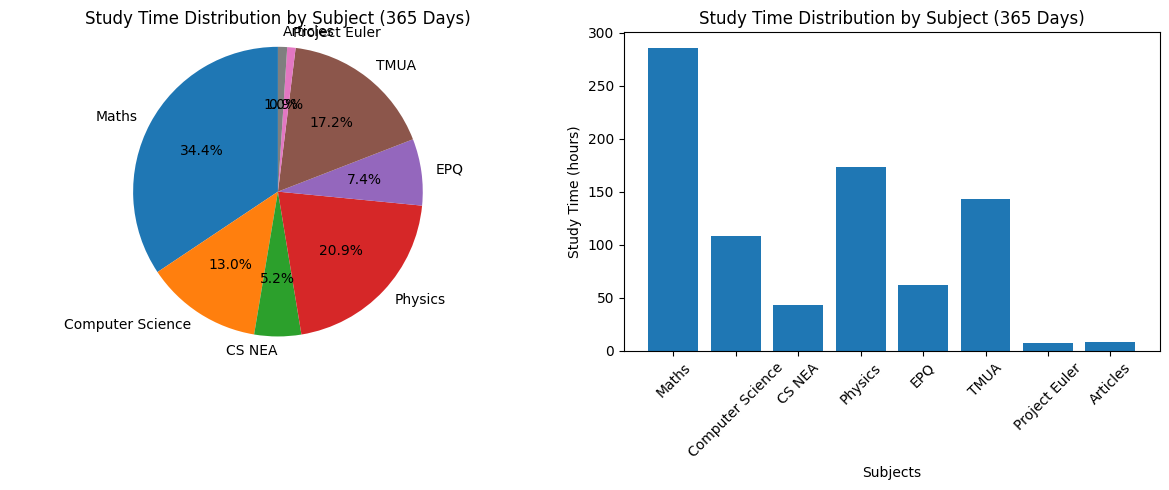

Found 0 events in the past 30 days from Studying.
Found 80 events in the past 30 days from Calendar.
Found 97 events in the past 30 days from Timetable.
Total study time in the past 30 days: 125.91666666666669 hours
Maths: 55.5 hrs, Computer Science: 20.8 hrs, CS NEA: 17.5 hrs, Physics: 32.2 hrs, 


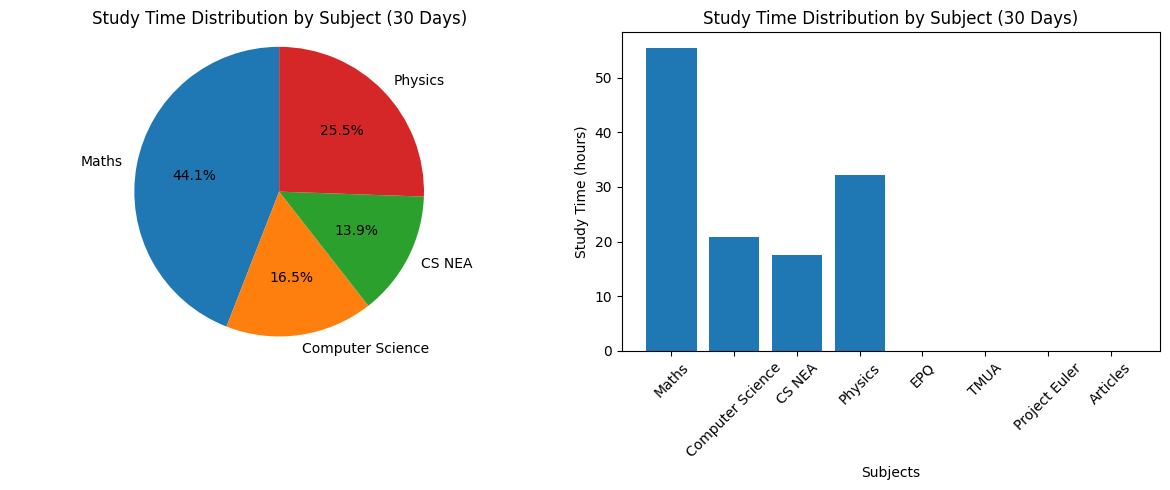

Found 0 events in the past 7 days from Studying.
Found 18 events in the past 7 days from Calendar.
Found 21 events in the past 7 days from Timetable.
Total study time in the past 7 days: 31.583333333333336 hours
Maths: 12.4 hrs, Computer Science: 4.9 hrs, CS NEA: 7.8 hrs, Physics: 6.5 hrs, 


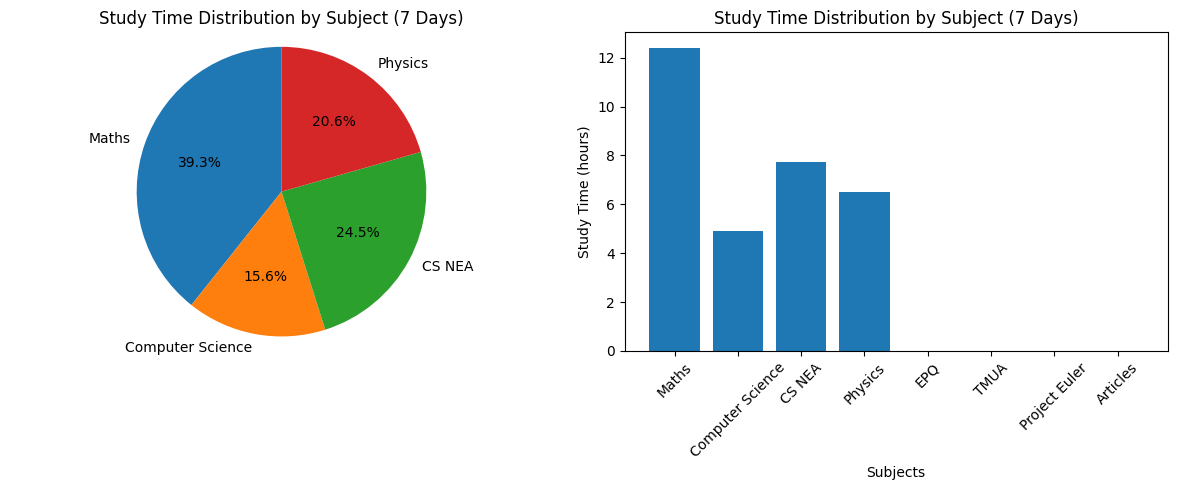

In [67]:
service = authenticate_google_calendar()
calendar_ids = [
    "0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com",
    "billjrimell@gmail.com",
    "b7ca60b7b46309b1e408a4a240a5456ca98cb4af51ad62d260ae8ae4fd0ce45d@group.calendar.google.com" # timetable
]

# Generate statistics and plots for different time periods
for days in [365, 30, 7]:
    study_stats(service, calendar_ids, num_previous_days=days)

No events found for today.
No events found for today.
Total planned studying hours for today (filtered by subjects): 5.0 hours
No events found for today.
No events found for today.
Total studying hours completed today: 2.0 hours
Percentage of planned studying hours completed today: 40%


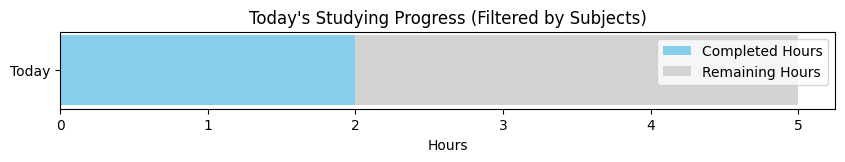

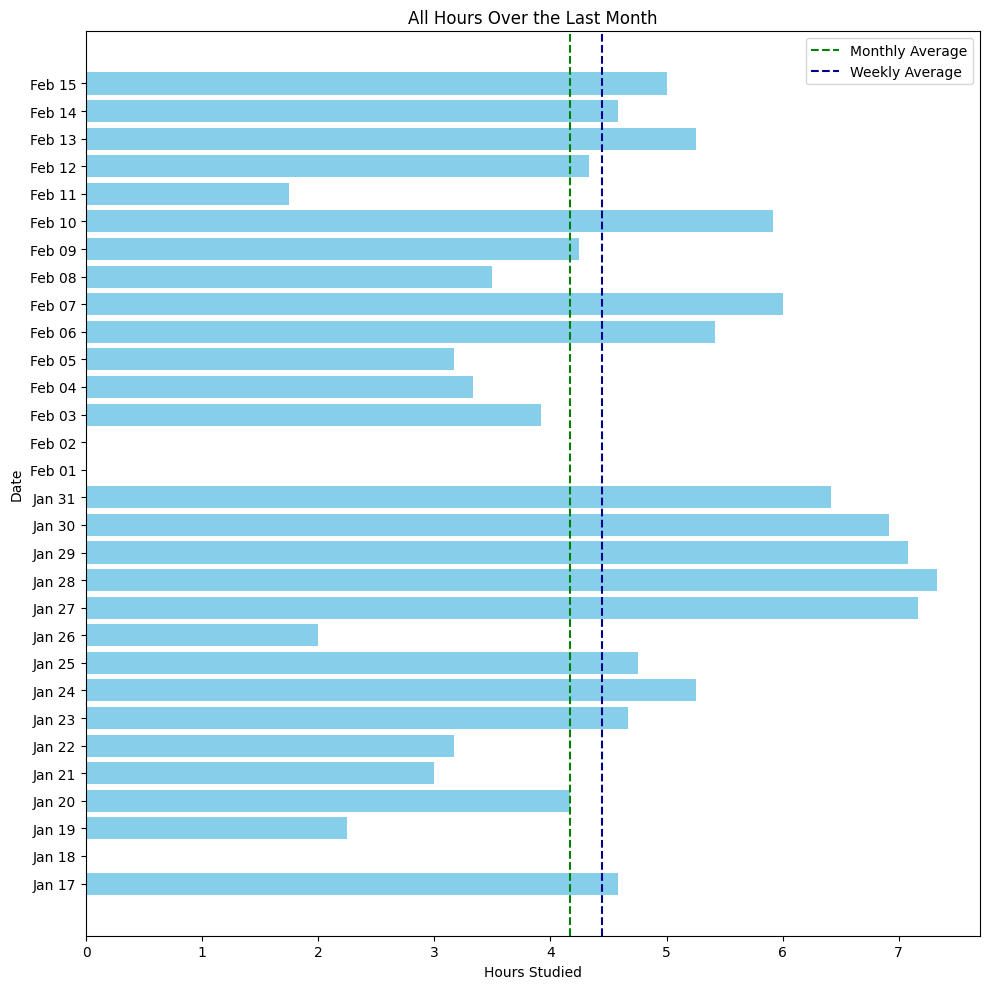

In [68]:
plot_studying_progress(service, calendar_ids, subjects)
# plot_studying_hours_over_past_month(service, calendar_ids[0])
plot_subject_hours_over_past_month(service, calendar_ids, subject=None, subjects=subjects)

In [69]:
# print(calculate_average_hours_since_date(service, calendar_ids[0], "TMUA", subjects, dt.datetime(2024, 5, 25)))

In [70]:
import datetime as dt

end_date = dt.datetime(2025, 2, 24)
current_date = dt.datetime.now()
days_remaining = (end_date - current_date).days
hours_per_day = 7
total_hours_studied = days_remaining * hours_per_day

print(f"Total hours studied by {end_date.strftime('%d %B %Y')}: {total_hours_studied} hours")
total_hours_per_subject = total_hours_studied / 3
print(f"Total hours per subject by {end_date.strftime('%d %B %Y')}: {total_hours_per_subject:.0f} hours")

Total hours studied by 24 February 2025: 56 hours
Total hours per subject by 24 February 2025: 19 hours
